In [1]:
import torch
from torch import nn
from pytorch_lightning import LightningModule
import torchvision as tv
from torchvision import transforms
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader

from collections import OrderedDict
from custom_layers import EqualizedConv2d, EqualizedLinear,\
    NormalizationLayer, Upscale2d
from pytorch_lightning.loggers import WandbLogger
import wandb

In [2]:
class Gen_residual(nn.Module): # only untill 32v32, later need to decrease no. channels in conv2
    def __init__(self, res, channels, device='cuda', start_alpha=0.1, activation_f=nn.LeakyReLU, normalize=True):
        super().__init__()
        self.alpha=start_alpha
        self.channels=channels
        self.f=activation_f
        self.device=device
        
        if normalize:
            self.normalization_layer=NormalizationLayer
        else:
            self.normalization_layer=nn.Identity
            
        if res>=64:
            self.model=nn.Sequential(
                        EqualizedConv2d(2*self.channels,self.channels,  padding=1, kernelSize=(3,3)),
                        self.f(),
                        self.normalization_layer(),
                        EqualizedConv2d(self.channels,self.channels,  padding=1, kernelSize=(3,3)),
                        self.f(),
                        self.normalization_layer(),
                        EqualizedConv2d(self.channels, 3, kernelSize=(1,1),  padding=0)
                        )
            self.introduce=nn.Sequential(
                        EqualizedConv2d(2*self.channels, 3, kernelSize=(1,1),  padding=0)
                        )
        else:
            self.model=nn.Sequential(
                        EqualizedConv2d(self.channels,self.channels,  padding=1, kernelSize=(3,3)),
                        self.f(),
                        self.normalization_layer(),
                        EqualizedConv2d(self.channels,self.channels,  padding=1, kernelSize=(3,3)),
                        self.f(),
                        self.normalization_layer(),
                        EqualizedConv2d(self.channels, 3, kernelSize=(1,1),  padding=0)
                        )
            self.introduce=nn.Sequential(
                        EqualizedConv2d(self.channels, 3, kernelSize=(1,1),  padding=0)
                        )
       # self.to_rgb=EqualizedConv2d(self.channels, 3, kernelSize=(1,1),  padding=0)
        self.model.to(self.device)
        self.introduce.to(self.device)
        
    def increase_alpha(self, by=0.1):
        self.alpha=max(self.alpha+by, 1)
    def forward(self, x):
        intro=self.introduce(x)
        #print(in_x.shape)
        out = self.model(x)
        #print(out.shape)
        #print(out.shape)
        
        return (1-self.alpha)*intro+self.alpha*out
    
class Dis_residual(nn.Module): # only untill 32v32, later need to decrease no. channels in conv2
    def __init__(self, res, channels, device='cuda',start_alpha=0.1, activation_f=nn.LeakyReLU, normalize=True):
        super().__init__()
        self.alpha=start_alpha
        self.channels=channels
        self.f=activation_f
        self.device=device
        
        if normalize:
            self.normalization_layer=NormalizationLayer
        else:
            self.normalization_layer=nn.Identity
            
        if res>=64:
            self.model=nn.Sequential(  # this is what stays on the pgan
                        EqualizedConv2d(3,self.channels,  padding=0, kernelSize=(1,1)), # from rgb
                        self.f(),
                        EqualizedConv2d(self.channels,self.channels,  padding=1, kernelSize=(3,3)),
                        self.f(),
                        EqualizedConv2d(self.channels,2*self.channels,  padding=1, kernelSize=(3,3)),
                        self.f(),
                        nn.AvgPool2d(kernel_size=2, stride=2)
                        )
            self.introduce=nn.Sequential( # this is just for introducing new scale
                        nn.AvgPool2d(kernel_size=2, stride=2),
                        EqualizedConv2d(3,2*self.channels,  padding=0, kernelSize=(1,1)) # from rgb
                        )
        else:
            self.model=nn.Sequential(  # this is what stays on the pgan
                        EqualizedConv2d(3,self.channels,  padding=0, kernelSize=(1,1)), # from rgb
                        self.f(),
                        EqualizedConv2d(self.channels,self.channels,  padding=1, kernelSize=(3,3)),
                        self.f(),
                        EqualizedConv2d(self.channels,self.channels,  padding=1, kernelSize=(3,3)),
                        self.f(),
                        nn.AvgPool2d(kernel_size=2, stride=2)
                        )
            self.introduce=nn.Sequential( # this is just for introducing new scale
                        nn.AvgPool2d(kernel_size=2, stride=2),
                        EqualizedConv2d(3,self.channels,  padding=0, kernelSize=(1,1)) # from rgb
                        )
        self.model.to(self.device)
        self.introduce.to(self.device)
        
    def increase_alpha(self, by=0.1):
        self.alpha=max(self.alpha+by, 1)
    def forward(self, x):
        intro=self.introduce(x)
        #print(in_x.shape)
        out = self.model(x)
        #print(out.shape)
        #print(out.shape)
        
        return (1-self.alpha)*intro+self.alpha*out

In [3]:
def num_flat_features(x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_size=512, final_res=32, device='cuda', normalize=True, activation_f=nn.LeakyReLU):
        super().__init__()
        #self.save_hyperparameters()
        self.curr_res=4
        self.final_res=final_res
        self.device=device
        
        self.res_chanel_dict={
                            4:512,
                            8:512,
                            16:512,
                            32:512,
                            64:256,
                            128:128,
                            256:64,
                            512:32,
                            1024:16
                             }
        
        if normalize:
            self.normalization_layer=NormalizationLayer
        else:
            self.normalization_layer=nn.Identity       
        
        self.f=activation_f
        self.layers=nn.Sequential(
                    EqualizedConv2d(latent_size,latent_size,  padding=3, kernelSize=(4,4)),
                    self.f(),
                    self.normalization_layer(),
                    EqualizedConv2d(latent_size,512,  padding=1, kernelSize=(3,3)),
                    self.f(),
                    self.normalization_layer(),
                    EqualizedConv2d(512, 3, kernelSize=(1,1),  padding=0)
                    )
        self.D=None
        
    def forward(self, x):
        x = x.view(-1, num_flat_features(x), 1, 1).to(self.device)
      #  print(x.shape)
        return self.layers(x)
        
    def add_discriminator(self, discirminator):
        self.D=discirminator
        
  #  def train_step(self, zi):
        #loss=torch.mean(torch.log(1-self.D(self(zi)))) #descend gradient, minimize
   #     loss=-torch.mean(torch.log(self.D(self(zi)))) # maximize, ascend gradient BUT torch optimis minimize loss, so return -mean
    #    
     #   return loss
        
    def add_scale(self, start_alpha=0.1): # average pooling in descriminator
        #if self.curr_res!=4:
         #   self.model[-1].to_rgb=nn.Identity()#remove to rgb
        #else:
        self.layers=self.layers[:-1]
        self.layers.append( nn.Upsample(scale_factor=(2,2), mode='nearest'))
        self.curr_res*=2
        next_layers=Gen_residual(self.curr_res, self.res_chanel_dict[self.curr_res], device=self.device,
                                 start_alpha=start_alpha, activation_f=self.f)
        self.layers.append(next_layers)
        #nn.upsample
        
    def increase_alpha(self, by=0.1):
        gen_res= self.layers[-1]
        gen_res.increase_alpha(by)
        
    def finish_adding_scale(self):
        gen_res= self.layers[-1]
        self.layers=torch.nn.Sequential(*(list(self.layers[:-1])+list(gen_res.model)))
       # self.layers.append(gen_res.to_rgb)
        

In [5]:
class Discriminator(nn.Module):
    def __init__(self, latent_size=512, final_res=32, device='cuda', normalize=True, activation_f=nn.LeakyReLU):
        super().__init__()
        #self.save_hyperparameters()
        self.device=device
        self.curr_res=4
        self.final_res=final_res
        self.transform=transforms.Resize((self.curr_res,self.curr_res))
        self.res_chanel_dict={
                            4:512,
                            8:512,
                            16:512,
                            32:512,
                            64:256,
                            128:128,
                            256:64,
                            512:32,
                            1024:16
                             }
        if normalize:
            self.normalization_layer=NormalizationLayer
        else:
            self.normalization_layer=nn.Identity
            
        self.f=activation_f
        self.layers=nn.Sequential(
                    EqualizedConv2d(3,512,  padding=0, kernelSize=(1,1)),
                    self.f(),
                    EqualizedConv2d(512,512,  padding=1, kernelSize=(3,3)),
                    self.f(),
                    EqualizedConv2d(512,latent_size,  padding=0, kernelSize=(4,4)),
                    self.f(),
                   # reshape(2,latent_size)
                 #   EqualizedLinear(latent_size, 1)
                    )
        self.decision_layer=EqualizedLinear(latent_size, 1)
       # self.from_rgb=EqualizedConv2d(3,512,  padding=0, kernelSize=(1,1))
        self.G=None
    
    def forward(self, x):
      #  x=self.from_rgb(x)
        x=self.transform(x)
        x=self.layers(x)
        x= x.view(-1, num_flat_features(x))
        out=self.decision_layer(x)
        return nn.Sigmoid()(out)
        
    def add_generator(self, generator):
        self.G=generator
        
 #   def train_step(self, xi, zi):
  #      loss_x=torch.log(self(xi)+1e-20)
   #     loss_z=torch.log(1-self(self.G(zi)))
    #    loss=torch.mean(loss_x+loss_z) 
     #   return -loss # ascend gradient, maximize. BUT torch optimis minimize loss, so return -loss
    
    def add_scale(self, start_alpha=0.1): # average pooling in descriminator
     #   self.layers=self.layers[1:]
       # self.layers.append( nn.AvgPool2d(kernelSize=2, stride=2)
        self.curr_res*=2
        self.transform=transforms.Resize((self.curr_res,self.curr_res))
        
        next_layers=Dis_residual(self.curr_res, self.res_chanel_dict[self.curr_res], device= self.device,
                                 start_alpha=start_alpha,  activation_f=self.f)
        self.layers[0]=next_layers
        
    def increase_alpha(self, by=0.1):
        dis_res= self.layers[0]
        dis_res.increase_alpha(by)
        
    def finish_adding_scale(self):
        dis_res= self.layers[0]
        self.layers=torch.nn.Sequential(*(list(dis_res.model)+list(self.layers[1:])))
      #  self.layers.append(dis_res.to_rgb)
        

In [34]:
class PGAN(pl.LightningModule):
    def __init__(self, lr=0.1, latent_size=512, final_res=32, curr_res=4, k=10,
                 alpha=0.0, normalize=True, activation_f=nn.LeakyReLU):
        super().__init__()
        self.save_hyperparameters()
        
        self.generator=Generator(latent_size=latent_size, final_res=final_res, normalize=normalize, activation_f=activation_f)
        self.discriminator=Discriminator(latent_size=latent_size, final_res=final_res, normalize=normalize, activation_f=activation_f)

    def forward(self, z):
        return self.generator(z)
    
    def training_step(self, batch,  batch_idx, optimizer_idx):
        xi, _=batch
        zi = torch.randn(xi.shape[0], self.hparams.latent_size) #TODO update zi sampling
        if self.hparams.normalize:
            zi=F.normalize(zi, dim=1, p=2)
        
        if optimizer_idx == 0: # train Generator
         #loss=torch.mean(torch.log(1-self.D(self(zi)))) #descend gradient, minimize
            gen_imgs=self.generator(zi)
            decisions=self.discriminator(gen_imgs)
            g_loss=-torch.mean(torch.log(decisions
                                )) # maximize, ascend gradient BUT torch optimis minimize loss, so return -mean

            #tqdm_dict = {"g_loss": g_loss,  "decisions": decisions}
            #output = OrderedDict({"loss": g_loss, "progress_bar": tqdm_dict, "log": tqdm_dict})
            
            self.log("generator_loss", g_loss)
            self.log("curr_res", self.hparams.curr_res)
            return g_loss
        
        if optimizer_idx>0: # train discriminator
            decisions_x=self.discriminator(xi)
            loss_x=torch.log(decisions_x+1e-20)
            
            decisions_z=self.discriminator(self.generator(zi))
            loss_z=torch.log(1-decisions_z)
            d_loss=-torch.mean(loss_x+loss_z) 
                                           
           # tqdm_dict = {"d_loss": d_loss, "loss_x": loss_x, "loss_z": loss_z, "decisions_x": decisions_x, "1-decisions_z": 1-decisions_z}
            #output = OrderedDict({"loss": d_loss, "progress_bar": tqdm_dict, "log": tqdm_dict})
            self.log("discriminator_loss", d_loss)
            self.log("curr_res", self.hparams.curr_res)
            return d_loss
          #  return d_loss # ascend gradient, maximize. BUT torch optimis minimize loss, so return -mean

    def on_train_epoch_end(self):
        if self.hparams.alpha==0:
            self.generator.add_scale(start_alpha=0.5)        
            self.discriminator.add_scale(start_alpha=0.5)
            self.hparams.alpha+=0.5
            self.hparams.curr_res*=2
            
            self.configure_optimizers()
            print(model.generator.layers[-1].model[0].module.weight.data[0,0])
        elif self.hparams.alpha>=1:
            self.generator.finish_adding_scale()
            self.discriminator.finish_adding_scale()
            self.hparams.alpha=0
            self.configure_optimizers()
          #  print(self.hparams.curr_res)
        else:
            self.generator.increase_alpha(by=0.4)
            self.discriminator.increase_alpha(by=0.4)
            self.hparams.alpha+=0.4
            
            print(model.generator.layers[-1].model[0].module.weight.data[0,0])
        
        
           
        

In [7]:
workers=8
batch_size=256

In [8]:
data_train=DataLoader(tv.datasets.CIFAR10("../data/01_raw",transform=transforms.ToTensor()), batch_size=batch_size, num_workers=workers)
data_val=DataLoader(tv.datasets.CIFAR10("../data/01_raw", transform=transforms.ToTensor() , train=False ), batch_size=batch_size, num_workers=workers)

In [40]:
list(data_train)[:1000]

[[tensor([[[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
            [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
            [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
            ...,
            [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
            [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
            [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
  
           [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
            [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
            [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
            ...,
            [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
            [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
            [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
  
           [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
            [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
      

In [9]:
model = PGAN(lr=1e-3, latent_size=512, final_res=4, activation_f=nn.LeakyReLU)
wandb.finish()
wandb_logger = WandbLogger(project="PGAN",  name='locally_with_normalization_2' ,entity="dl_image_classification")

wandb: Currently logged in as: kpuchalskixiv (dl_image_classification). Use `wandb login --relogin` to force relogin


In [10]:
model.generator.device='cuda'
trainer = Trainer(gpus=1, max_epochs=5, progress_bar_refresh_rate=5, log_every_n_steps=50, logger=wandb_logger)
trainer.fit(model, data_train)

C:\Users\kpuch\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=5)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 6.6 M 
1 | discriminator | Discriminator | 6.6 M 
------------------------------------------------
13.1 M    Trainable params
0         Non-trainable params
13.1 M    Total params
52.453    Total esti

Training: 0it [00:00, ?it/s]

C:\Users\kpuch\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:229: UserWarning: You called `self.log('curr_res', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


8


In [11]:
torch.save(model, 'model_16_locall.model')

# Debugging

In [11]:

model.generator.device='cpu'

In [102]:
# before training
for d in data_train:
    print( model.training_step(d, batch_idx=1, optimizer_idx=0)['progress_bar'])
    print( model.training_step(d, batch_idx=1, optimizer_idx=1)['progress_bar'])
    break

{'g_loss': tensor(1.4855, grad_fn=<NegBackward0>), 'decisions': tensor([[-1.0740e+00],
        [-1.7470e+00],
        [-8.8313e-01],
        [-1.3695e+00],
        [-2.0149e+00],
        [-6.8298e-01],
        [-1.9016e+00],
        [-2.9784e+00],
        [-1.3172e+00],
        [-1.4781e+00],
        [-8.7979e-01],
        [-3.2429e+00],
        [-5.0971e+00],
        [-2.4300e+00],
        [-1.3933e+00],
        [-9.2975e-01],
        [-1.6207e+00],
        [-8.3027e-01],
        [-1.6638e+00],
        [ 1.0752e-01],
        [ 1.3924e-01],
        [-1.7843e+00],
        [-5.3831e-01],
        [-1.1140e-01],
        [-8.5807e-01],
        [-1.3884e+00],
        [-1.2412e+00],
        [-4.6832e-01],
        [-2.8184e+00],
        [-5.4075e-01],
        [-1.2016e+00],
        [-2.7460e+00],
        [-9.9232e-01],
        [-5.7026e-01],
        [-1.4369e+00],
        [-2.5956e+00],
        [-2.9929e+00],
        [-7.3568e-02],
        [-2.3233e-01],
        [-1.9280e+00],
        [-8.8293

In [131]:
#after Training
for d in data_train:
    print( model.training_step(d, batch_idx=1, optimizer_idx=0)['progress_bar'])
    print( model.training_step(d, batch_idx=1, optimizer_idx=1)['progress_bar'])
    break

{'g_loss': tensor(-6.2294, grad_fn=<NegBackward0>)}
{'d_loss': tensor(nan, grad_fn=<NegBackward0>), 'loss_x': tensor([[5.1189],
        [5.3617],
        [5.2065],
        [4.8873],
        [5.0891],
        [4.9586],
        [5.2412],
        [5.2268],
        [5.4860],
        [4.5550],
        [4.7472],
        [5.3273],
        [5.2567],
        [4.8555],
        [4.8960],
        [5.3301],
        [5.3217],
        [4.9928],
        [5.2026],
        [5.2211],
        [5.5726],
        [5.1602],
        [4.7168],
        [4.9964],
        [4.8869],
        [5.2290],
        [4.8341],
        [4.6833],
        [5.2088],
        [5.2866],
        [5.2577],
        [5.2240],
        [5.0407],
        [5.2927],
        [5.2307],
        [5.1277],
        [5.4857],
        [4.8675],
        [5.3534],
        [5.1685],
        [5.1528],
        [5.6335],
        [5.2939],
        [5.2824],
        [5.0656],
        [4.9872],
        [5.2226],
        [5.0657],
        [5.6284],
        

In [33]:
model.generator.layers[-1].model[0].module.weight.data[0,0]

tensor([[ 0.9664,  1.0326, -0.2024],
        [ 1.7970, -0.5942,  0.2666],
        [-0.0060,  0.2152, -0.2574]])

In [12]:
latent_vec=F.normalize(torch.rand(40,512), p=2, dim=1)
latent_vec

tensor([[0.0053, 0.0216, 0.0258,  ..., 0.0644, 0.0280, 0.0101],
        [0.0071, 0.0173, 0.0656,  ..., 0.0255, 0.0379, 0.0034],
        [0.0056, 0.0283, 0.0256,  ..., 0.0180, 0.0436, 0.0046],
        ...,
        [0.0658, 0.0524, 0.0269,  ..., 0.0623, 0.0403, 0.0566],
        [0.0326, 0.0184, 0.0463,  ..., 0.0617, 0.0420, 0.0696],
        [0.0353, 0.0071, 0.0137,  ..., 0.0568, 0.0041, 0.0766]])

In [143]:
nn.Sigmoid()(torch.tensor([1.0]))

tensor([0.7311])

In [147]:
imgs=(model.generator(latent_vec.to('cpu')))
print(imgs)
nn.Sigmoid()(-model.discriminator(imgs))

tensor([[[[ 0.7558,  0.7546,  0.5537,  0.5530,  1.2885,  1.2887,  1.0943,
            1.0949],
          [ 0.7559,  0.7551,  0.5534,  0.5536,  1.2895,  1.2907,  1.0962,
            1.0948],
          [ 0.3966,  0.3957,  1.7374,  1.7385,  1.3529,  1.3532,  1.6918,
            1.6901],
          [ 0.3977,  0.3962,  1.7377,  1.7387,  1.3540,  1.3525,  1.6906,
            1.6916],
          [ 0.0557,  0.0550,  1.7935,  1.7929,  1.9209,  1.9217,  1.2800,
            1.2805],
          [ 0.0556,  0.0542,  1.7932,  1.7929,  1.9212,  1.9219,  1.2797,
            1.2791],
          [ 0.3715,  0.3698,  0.6494,  0.6490, -0.0521, -0.0517, -0.1387,
           -0.1398],
          [ 0.3706,  0.3708,  0.6507,  0.6504, -0.0509, -0.0508, -0.1370,
           -0.1374]],

         [[-2.5810, -2.5798, -1.0827, -1.0825, -2.9366, -2.9362, -2.5257,
           -2.5276],
          [-2.5825, -2.5815, -1.0830, -1.0834, -2.9378, -2.9380, -2.5264,
           -2.5285],
          [-2.1119, -2.1107, -1.6490, -1.6486, -

tensor([[0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SigmoidBackward0>)

In [14]:
l=model.generator.layers

In [17]:
latent_vec=latent_vec.reshape(-1, 512, 1,1)

NameError: name 'latent_vec' is not defined

In [96]:
l[0](latent_vec)

tensor([[[[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         ...,

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
         

In [99]:
l[3].module.weight.data

tensor([[[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         ...,

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         ...,

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
 

In [35]:
for p in l[0].parameters():
    print(p)

Parameter containing:
tensor([[[[-0.8131, -1.1130, -0.6177,  0.9079],
          [-1.5165,  1.0409,  0.4736, -0.1530],
          [ 2.1715,  1.5632,  0.0508,  0.4203],
          [ 0.4826,  0.1417,  0.6424,  0.4342]],

         [[-0.6208,  0.9588,  0.0723, -0.4741],
          [-1.6884, -0.6576, -1.9421, -0.2902],
          [ 1.0482,  0.6270, -0.4965, -0.0996],
          [-1.7199, -0.6549,  0.3305, -0.0205]],

         [[-0.5111, -0.2931, -0.1302, -0.1932],
          [-0.5306, -0.6453,  0.7222,  0.4759],
          [-0.3501,  1.4179,  0.7693, -0.3961],
          [ 0.2473,  0.3302,  0.3027, -0.8690]],

         ...,

         [[ 0.2465, -0.5740, -2.1357,  1.5009],
          [ 0.4205, -1.1134, -0.0403,  1.3236],
          [-1.2211,  0.0833, -0.9492, -0.1530],
          [-1.1583, -0.7793,  2.4797, -1.3603]],

         [[-1.5437, -2.1164, -2.7015, -1.0275],
          [-1.1058, -0.8205, -0.1889, -1.3645],
          [ 0.0239, -0.7328, -0.7459, -0.5425],
          [-1.4664, -0.1581, -0.2447, -0.43

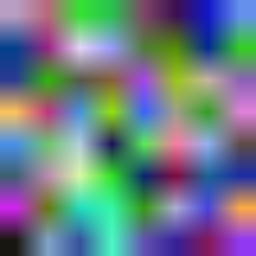

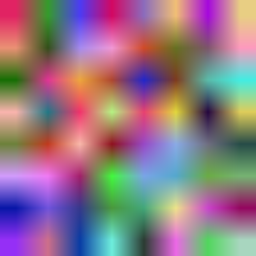

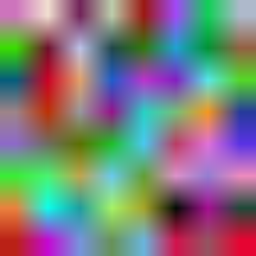

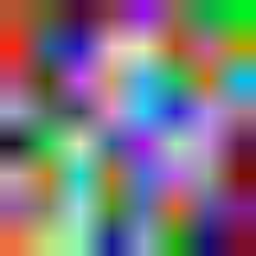

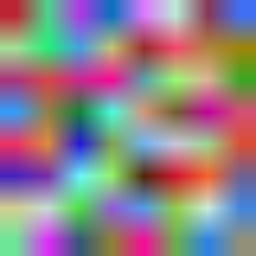

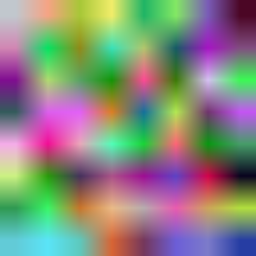

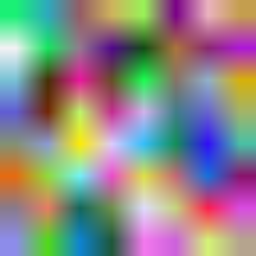

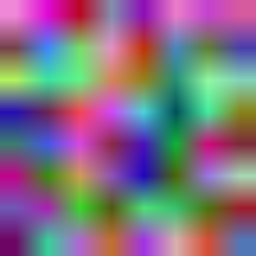

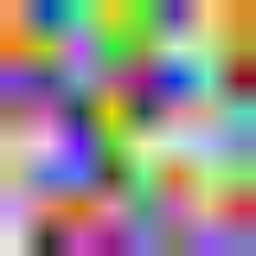

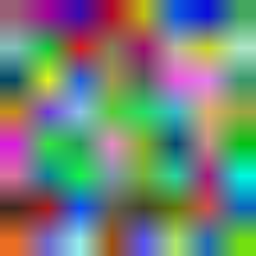

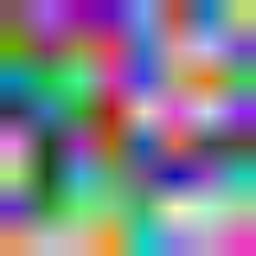

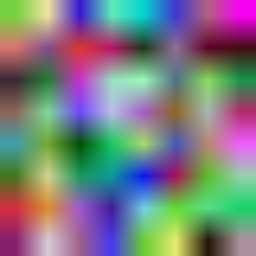

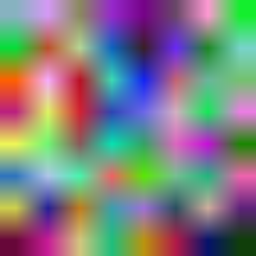

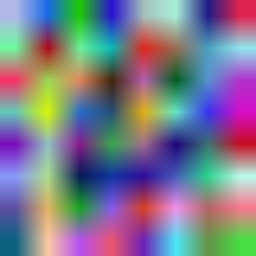

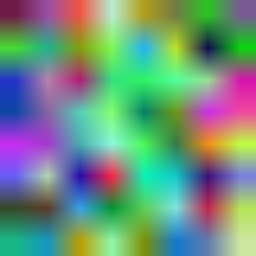

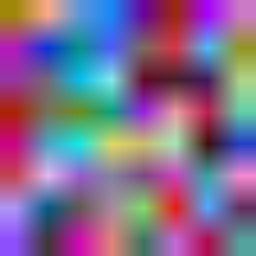

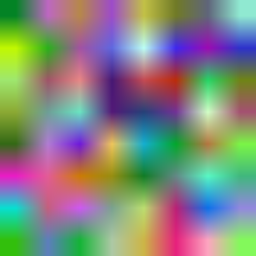

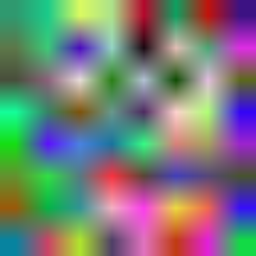

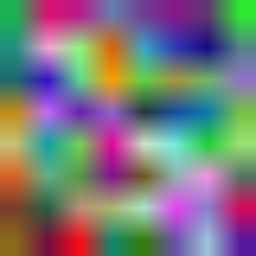

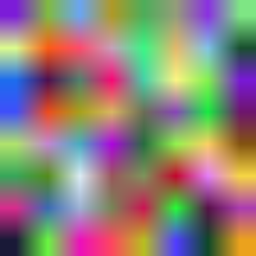

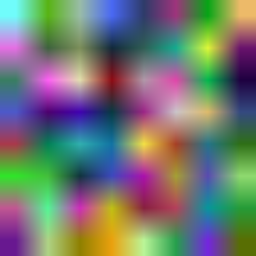

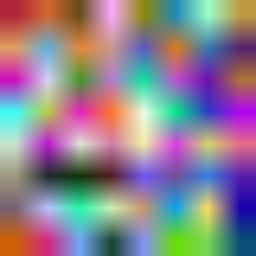

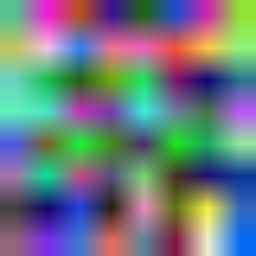

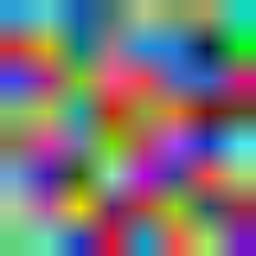

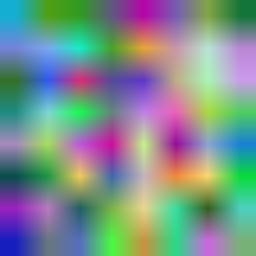

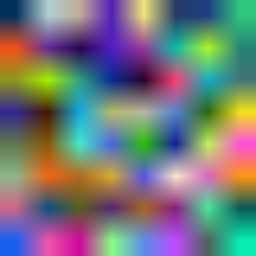

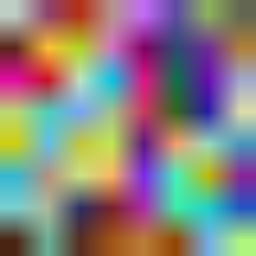

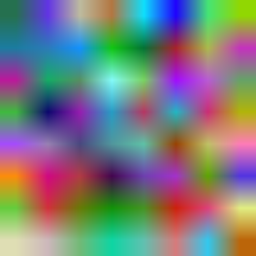

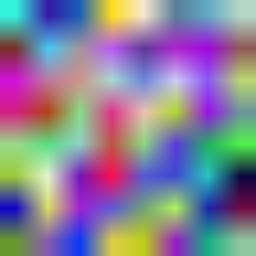

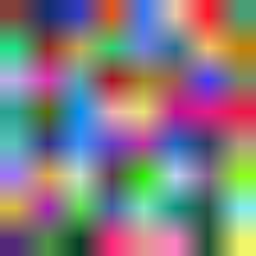

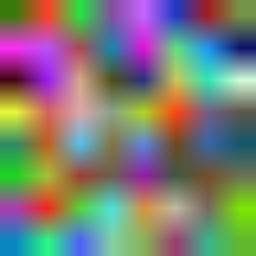

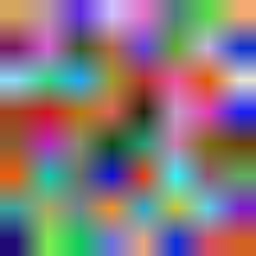

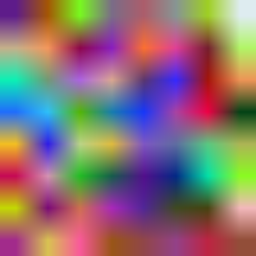

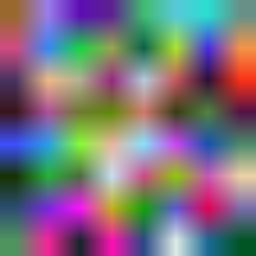

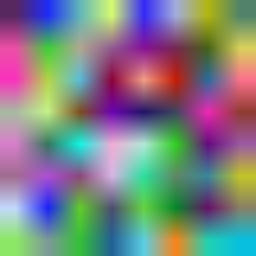

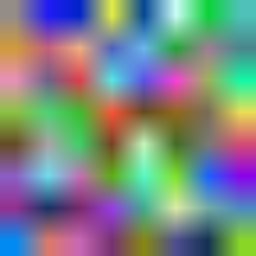

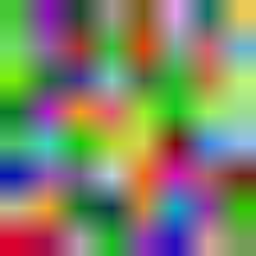

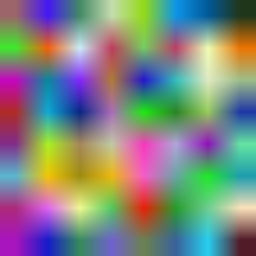

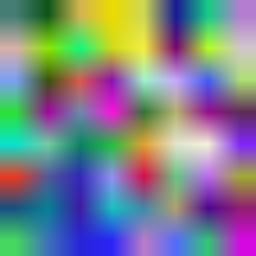

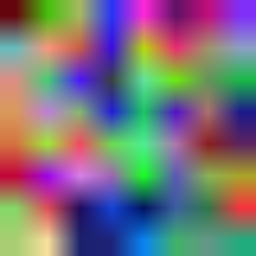

In [17]:
model.generator.device='cpu'
gen_imgs=model.generator(latent_vec)
t=transforms.Compose([transforms.ToPILImage(), transforms.Resize(size=(256,256))])
for img in gen_imgs: 
   # imgs.append(t(img))
    display(t(img))

In [56]:
gen=Generator(device='cpu')

In [57]:
dis=Discriminator(device='cpu')

In [63]:
print(latent_vec.shape)
gen_imgs=gen(latent_vec)
(gen_imgs.shape)

torch.Size([4, 512])


torch.Size([4, 3, 8, 8])

In [64]:
decision=dis(gen_imgs)
decision.shape

torch.Size([4, 1])

In [478]:
#t=transforms.ToPILImage()
#imgs=[]
t=transforms.ToPILImage()
for img in gen_imgs: 
   # imgs.append(t(img))
    display(t(img))
#display(imgs[0]), display(imgs[1]), display(imgs[2]), display(imgs[3])

In [61]:
#gen.finish_adding_scale()
gen.add_scale()
#gen.finish_adding_scale()
gen.layers

Sequential(
  (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3))
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): LeakyReLU(negative_slope=0.01)
  (4): Upsample(scale_factor=(2.0, 2.0), mode=nearest)
  (5): Gen_residual(
    (model): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(512, 3, kernel_size=(1, 1), stride=(1, 1))
    )
    (introduce): Sequential(
      (0): Conv2d(512, 3, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

In [62]:
#dis.finish_adding_scale()
dis.add_scale()
#dis.finish_adding_scale()
dis.layers

Sequential(
  (0): Dis_residual(
    (model): Sequential(
      (0): Conv2d(3, 512, kernel_size=(1, 1), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.01)
      (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (introduce): Sequential(
      (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (1): Conv2d(3, 512, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): LeakyReLU(negative_slope=0.01)
  (4): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1))
  (5): LeakyReLU(negative_slope=0.01)
)

In [419]:
print(latent_vec.shape)
gen_imgs=gen(latent_vec)
print(gen_imgs.shape)

torch.Size([4, 512])
torch.Size([4, 3, 16, 16])


In [420]:
decision=dis(gen_imgs)
decision.shape, decision

(torch.Size([4, 1]),
 tensor([[0.0236],
         [0.0236],
         [0.0236],
         [0.0236]], grad_fn=<AddmmBackward0>))